In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import scgenmulti
from matplotlib import pyplot as plt
import seaborn as sns
import gc
import os
import tensorflow as tf

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format='retina'

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# Load the Dataset

In [6]:
SCRNA_DIR = '../data/scRNA/'
SCATAC_DIR = '../data/scATAC/'

## scRNA

In [7]:
%time scrna = sc.read_h5ad(SCRNA_DIR + 'expressions.h5ad')
scrna

CPU times: user 444 ms, sys: 156 ms, total: 600 ms
Wall time: 1.74 s


AnnData object with n_obs × n_vars = 53638 × 3000 
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'cell_type', 'Barcode', 'condition'
    var: 'gene_name', 'gene_id', 'exonLength', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Group_colors', 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'

## scATAC

In [8]:
%time scatac = sc.read_h5ad(SCATAC_DIR + 'peaks.h5ad')
scatac

CPU times: user 1.41 s, sys: 22.7 s, total: 24.1 s
Wall time: 37.6 s


AnnData object with n_obs × n_vars = 70461 × 20002 
    obs: 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'cell_type', 'condition', 'nb_features', 'n_counts'
    var: 'score', 'scoreQuantile', 'name', 'GC', 'n_cells', 'prop_shared_cells', 'variability_score'
    uns: 'Group_colors', 'cell_type_colors', 'condition_colors'
    obsm: 'X_umap'

# Train the model

In [9]:
network = scgenmulti.VAEArithKeras([scrna.shape[1], scatac.shape[1]],
                                    h_dimension=100, z_dimension=10, other_dimension=800,
                                    learning_rate=0.0001, alpha=0.01)

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 3000)         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 20002)        0                                            
__________________________________________________________________________________________________
VAE_0 (Model)                   (None, 3000)         6447020     input_0[0][0]                    
__________________________________________________________________________________________________
VAE_1 (Model)                   (None, 20002)        33667222    input_1[0][0]                    
Total params: 38,637,022
Trainable params: 38,623,622
Non-trainable params: 13,400
_____________

In [10]:
batch_size = 30000
n_iter = 20
i, j, n = 0, 0, 0
history = []
for n in range(n_iter):
    print('-' * 50)
    print('Iteration: {}'.format(n))
    if i + batch_size < scrna.shape[0]:
        scrna_batch = scrna[i:i+batch_size]
    else:
        select = list(range(i, scrna.shape[0]))
        select += list(range(i + batch_size - scrna.shape[0]))
        scrna_batch = scrna[select]
    if j + batch_size < scatac.shape[0]:
        scatac_batch = scatac[j:j+batch_size]
    else:
        select = list(range(j, scatac.shape[0]))
        select += list(range(j + batch_size - scatac.shape[0]))
        scatac_batch = scatac[select]
        
    i = (i + batch_size) % scrna.shape[0]
    j = (j + batch_size) % scatac.shape[0]
    
    %time history.append(network.train([scrna_batch, scatac_batch], n_epochs=1, batch_size=128, verbose=1))
    
    del scrna_batch
    del scatac_batch
    gc.collect()

--------------------------------------------------
Iteration: 0

Epoch 1/1
30000/30000 [==============================] - 19s 639us/step - loss: 1011.6352 - VAE_0_loss: 226.4323 - VAE_1_loss: 784.9451 - VAE_0_kl_loss: 112.6674 - VAE_0_recon_loss: 225.4473 - VAE_1_kl_loss: 112.6674 - VAE_1_recon_loss: 783.9345
CPU times: user 39.6 s, sys: 11.1 s, total: 50.7 s
Wall time: 46.1 s
--------------------------------------------------
Iteration: 1
Epoch 1/1
30000/30000 [==============================] - 15s 498us/step - loss: 868.1694 - VAE_0_loss: 188.2487 - VAE_1_loss: 679.8900 - VAE_0_kl_loss: 122.6886 - VAE_0_recon_loss: 187.0283 - VAE_1_kl_loss: 122.6886 - VAE_1_recon_loss: 678.6872
CPU times: user 23 s, sys: 9.49 s, total: 32.5 s
Wall time: 26.7 s
--------------------------------------------------
Iteration: 2
Epoch 1/1
30000/30000 [==============================] - 14s 463us/step - loss: 895.0721 - VAE_0_loss: 163.8338 - VAE_1_loss: 731.1368 - VAE_0_kl_loss: 110.0095 - VAE_0_recon_loss:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


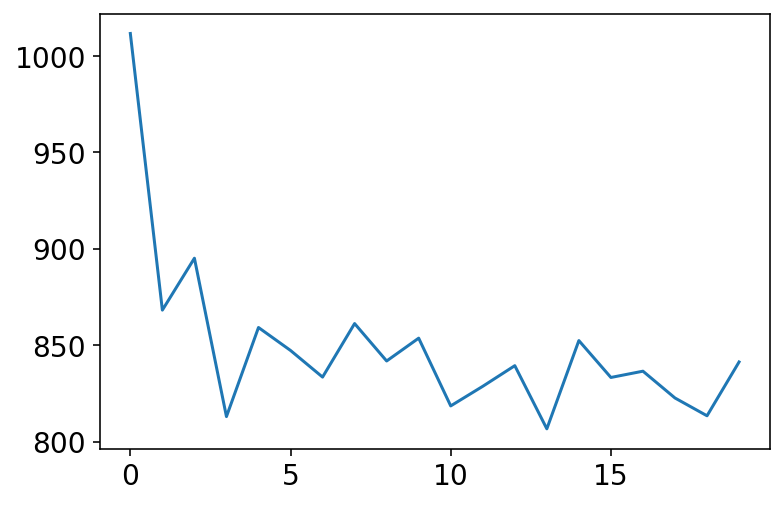

In [11]:
plt.plot([i.history['loss'] for i in history]);

# Visualization

## scRNA

In [12]:
scrna_latent = network.to_latent(scrna.X, 0)[0]
scrna_latent = sc.AnnData(scrna_latent)
scrna_latent.obs = scrna.obs

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anac

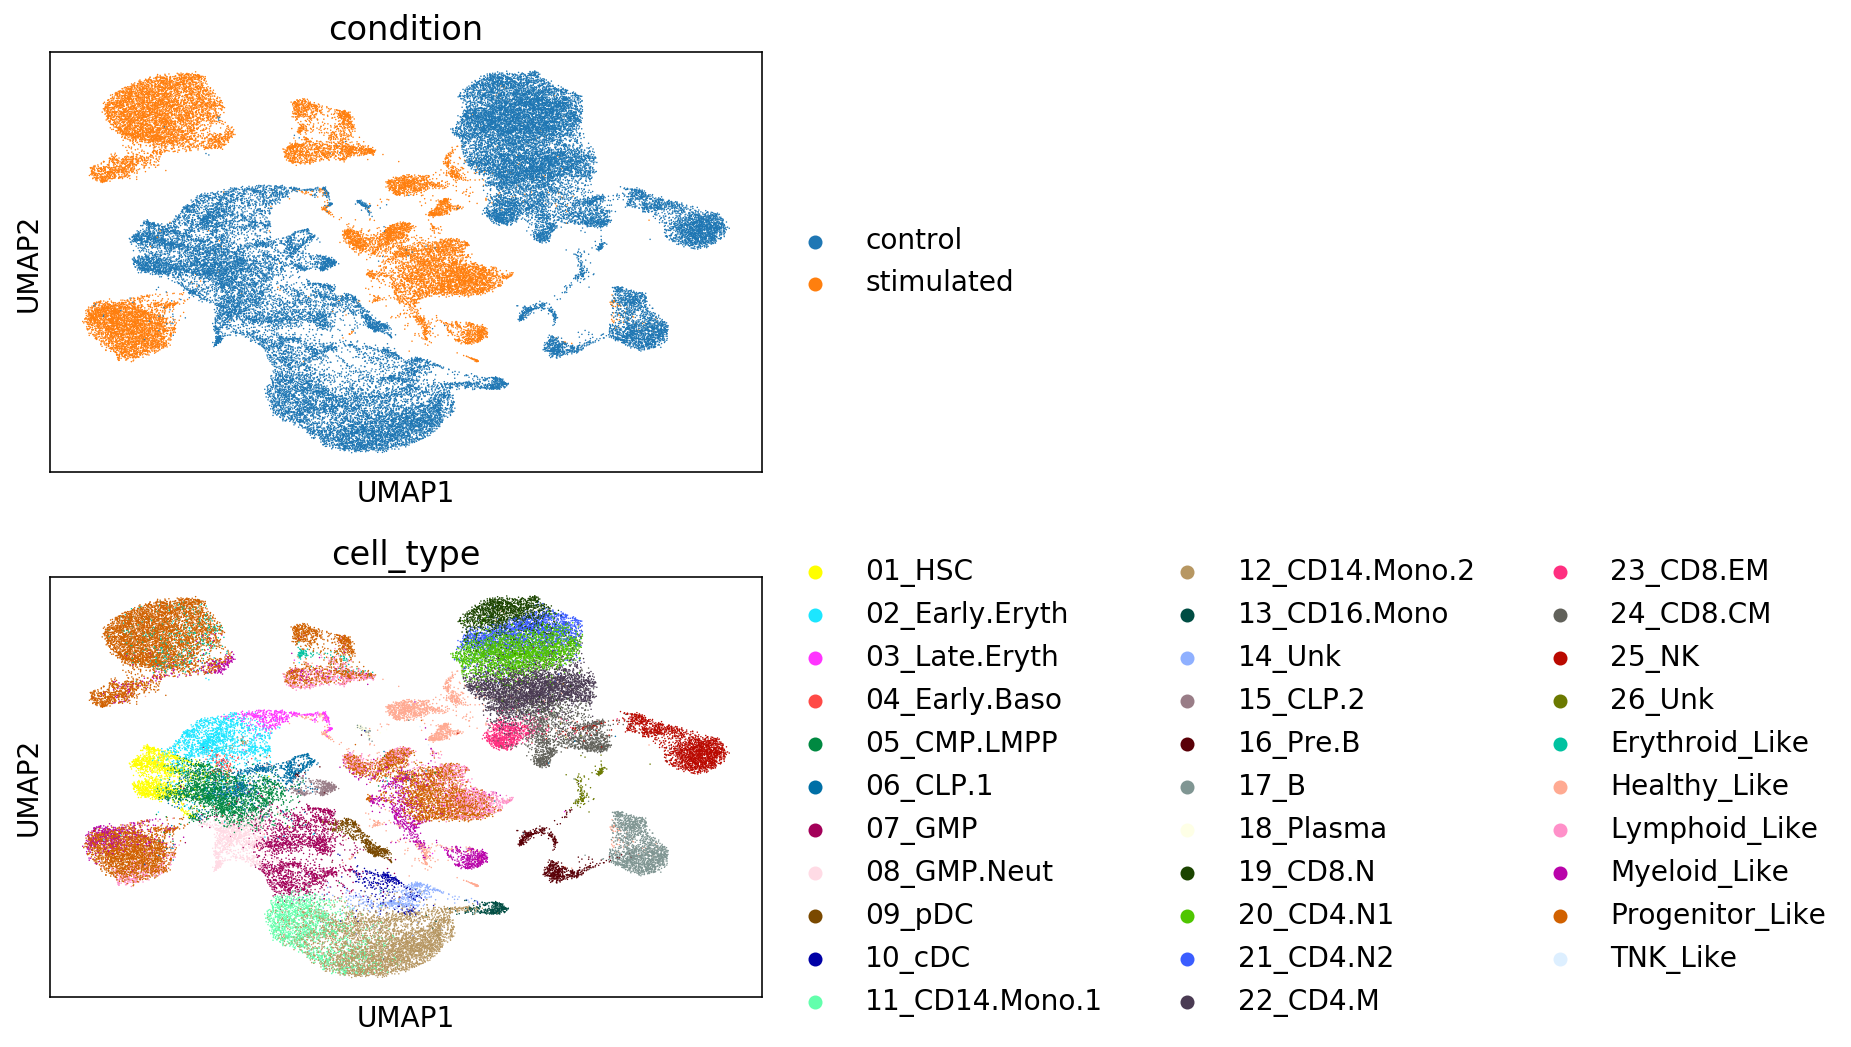

In [13]:
sc.pp.neighbors(scrna_latent, random_state=42)
sc.tl.umap(scrna_latent, random_state=42)
sc.pl.umap(scrna_latent, color=['condition', 'cell_type'], ncols=1)

## scATAC

In [14]:
scatac_latent = network.to_latent(scatac.X, 1)[0]
scatac_latent = sc.AnnData(scatac_latent)
scatac_latent.obs = scatac.obs

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


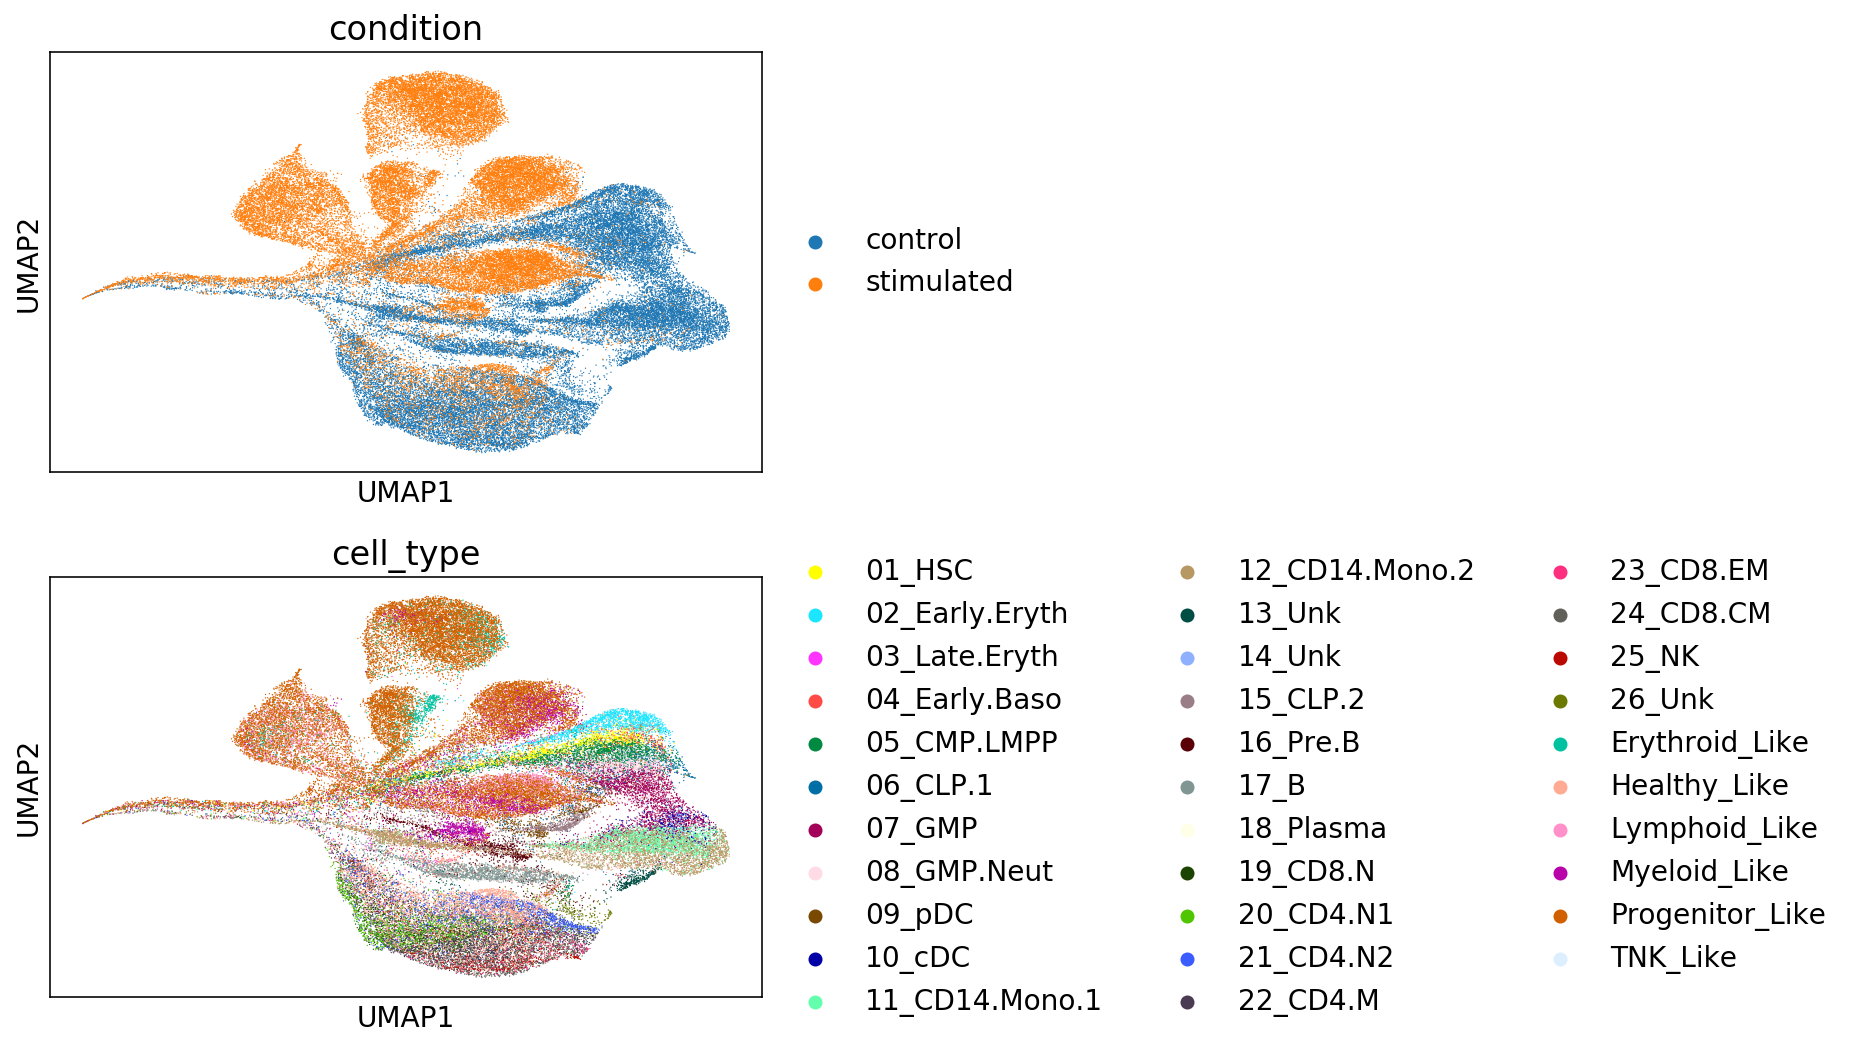

CPU times: user 5min 33s, sys: 6.5 s, total: 5min 40s
Wall time: 2min 37s


In [15]:
%%time
sc.pp.neighbors(scatac_latent, random_state=42)
sc.tl.umap(scatac_latent, random_state=42)
sc.pl.umap(scatac_latent, color=['condition', 'cell_type'], ncols=1)

## scRNA + scATAC

In [16]:
scall_latent = np.concatenate([scrna_latent.X, scatac_latent.X], axis=0)

scall_latent = sc.AnnData(scall_latent)
scrnaobs = scrna.obs
scatacobs = scatac.obs
scrnaobs['modal'] = 'scRNA'
scatacobs['modal'] = 'scATAC'

scall_latent.obs = pd.concat([scrnaobs, scatacobs])

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
... storing 'Group' as categorical
... storing 'cell_type' as categorical
... storing 'Barcode' as categorical
... storing 'modal' as categorical
... storing 'initialClusters' as categorical
... storing 'Clusters' as categorical


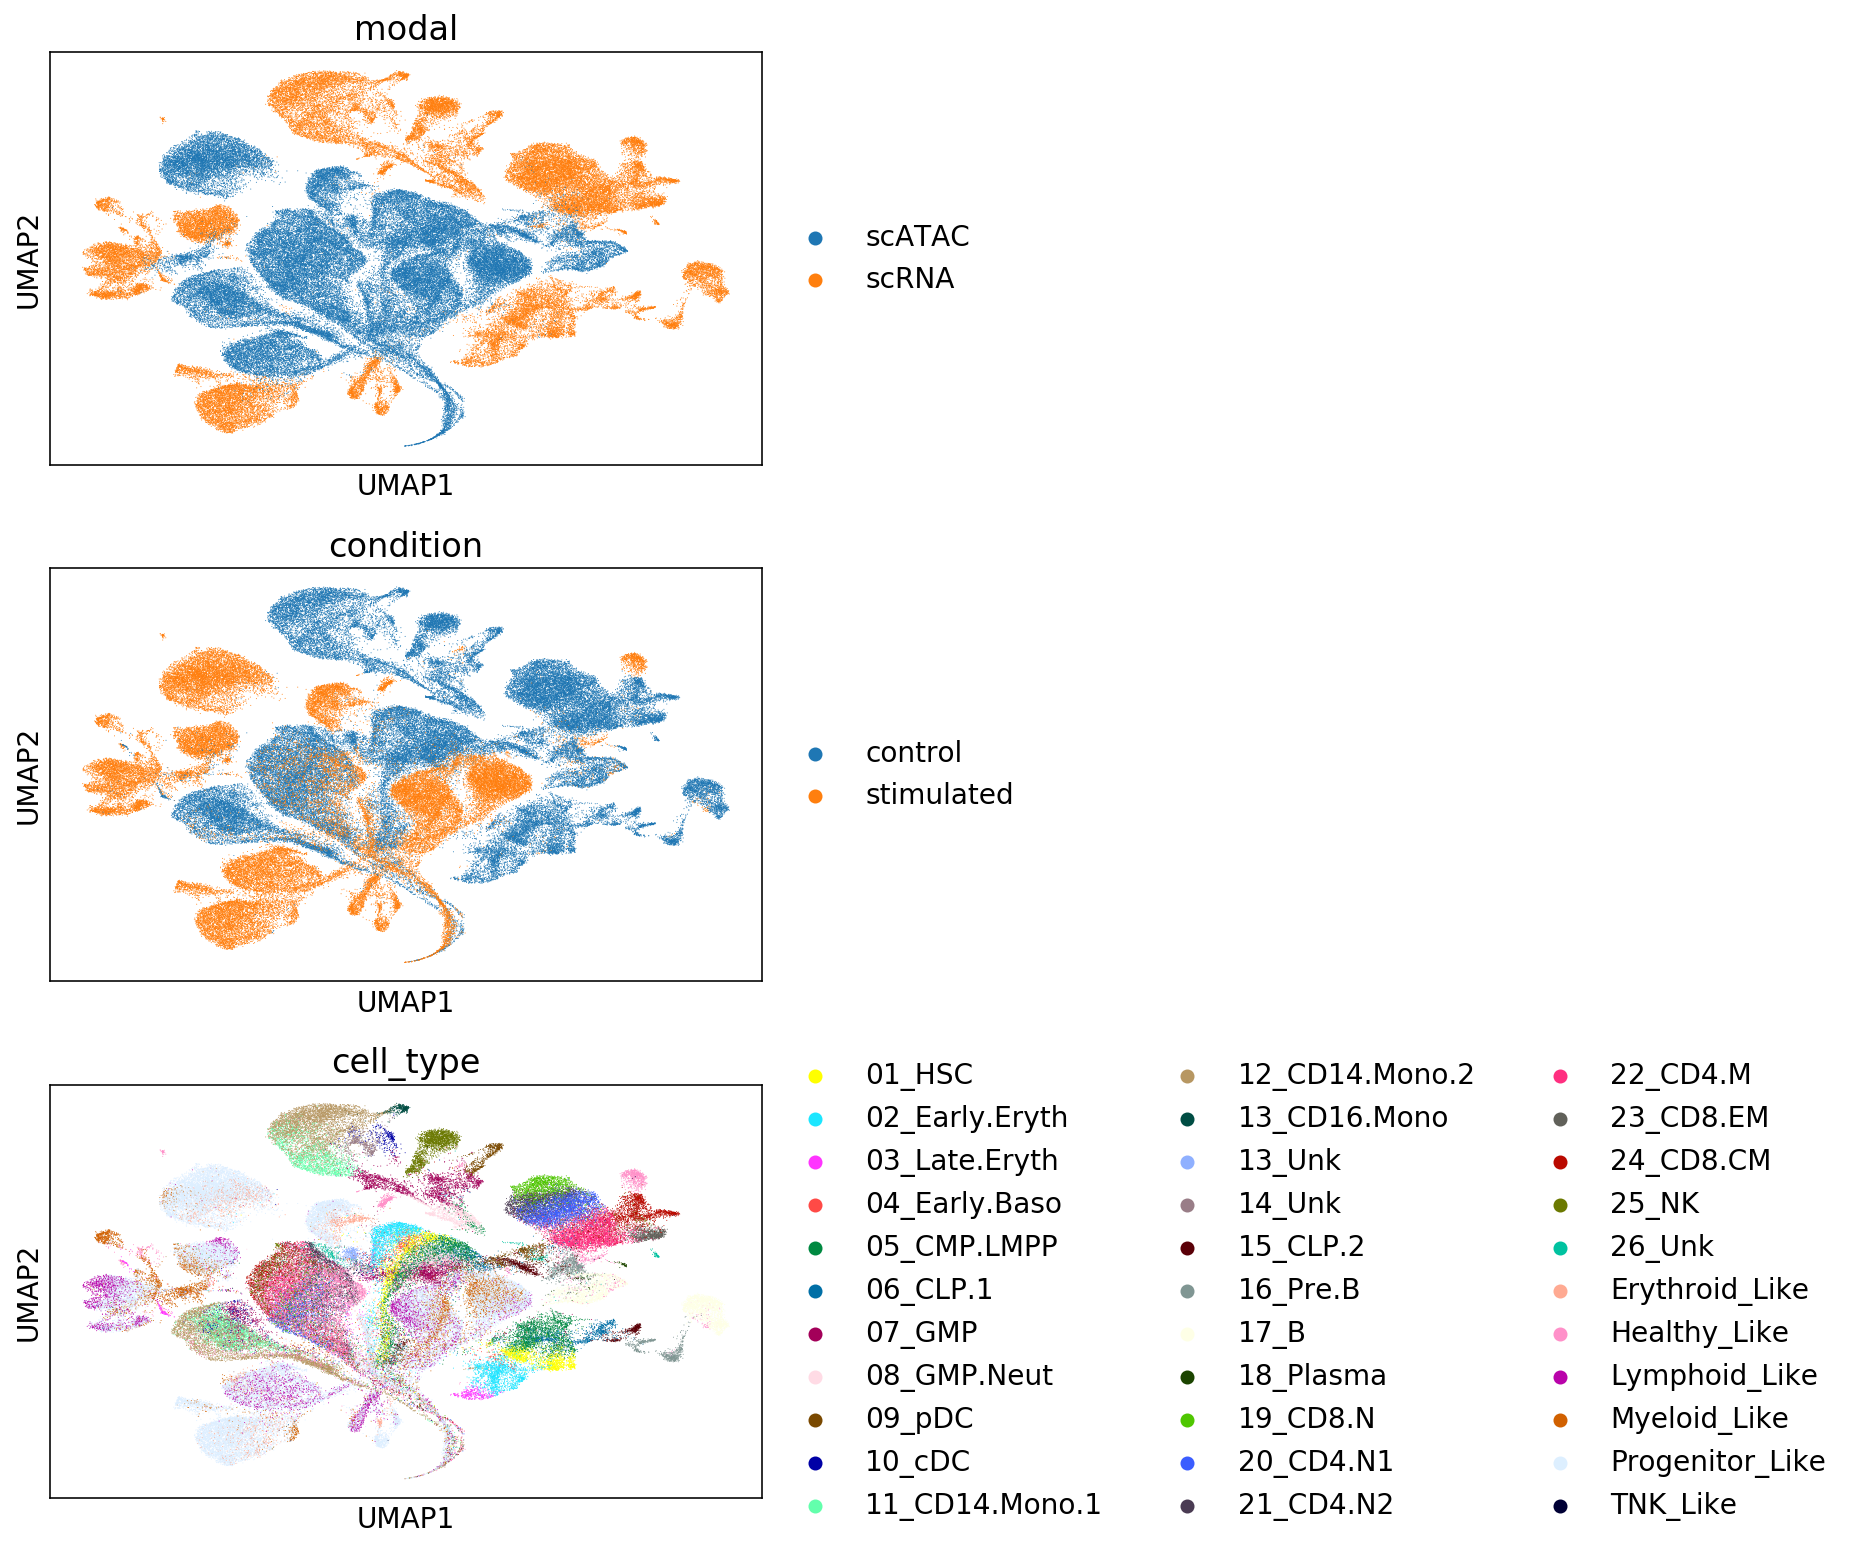

CPU times: user 15min 54s, sys: 22.9 s, total: 16min 17s
Wall time: 5min 52s


In [17]:
%%time
sc.pp.neighbors(scall_latent, random_state=42)
sc.tl.umap(scall_latent, random_state=42)
sc.pl.umap(scall_latent, color=['modal', 'condition', 'cell_type'], ncols=1)

# Integrate

In [18]:
delta = np.mean(scatac_latent.X, axis=0, keepdims=True) - np.mean(scrna_latent.X, axis=0, keepdims=True)
delta

array([[-0.6071841 , -0.29767406,  0.08155677,  0.17881262, -0.497635  ,
        -0.9479538 , -0.27166265, -0.3326134 ,  0.14250493,  0.23392376]],
      dtype=float32)

In [19]:
scall_latent_intg = scall_latent
scall_latent_intg[scall_latent_intg.obs['modal'] == 'scRNA'].X += delta

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


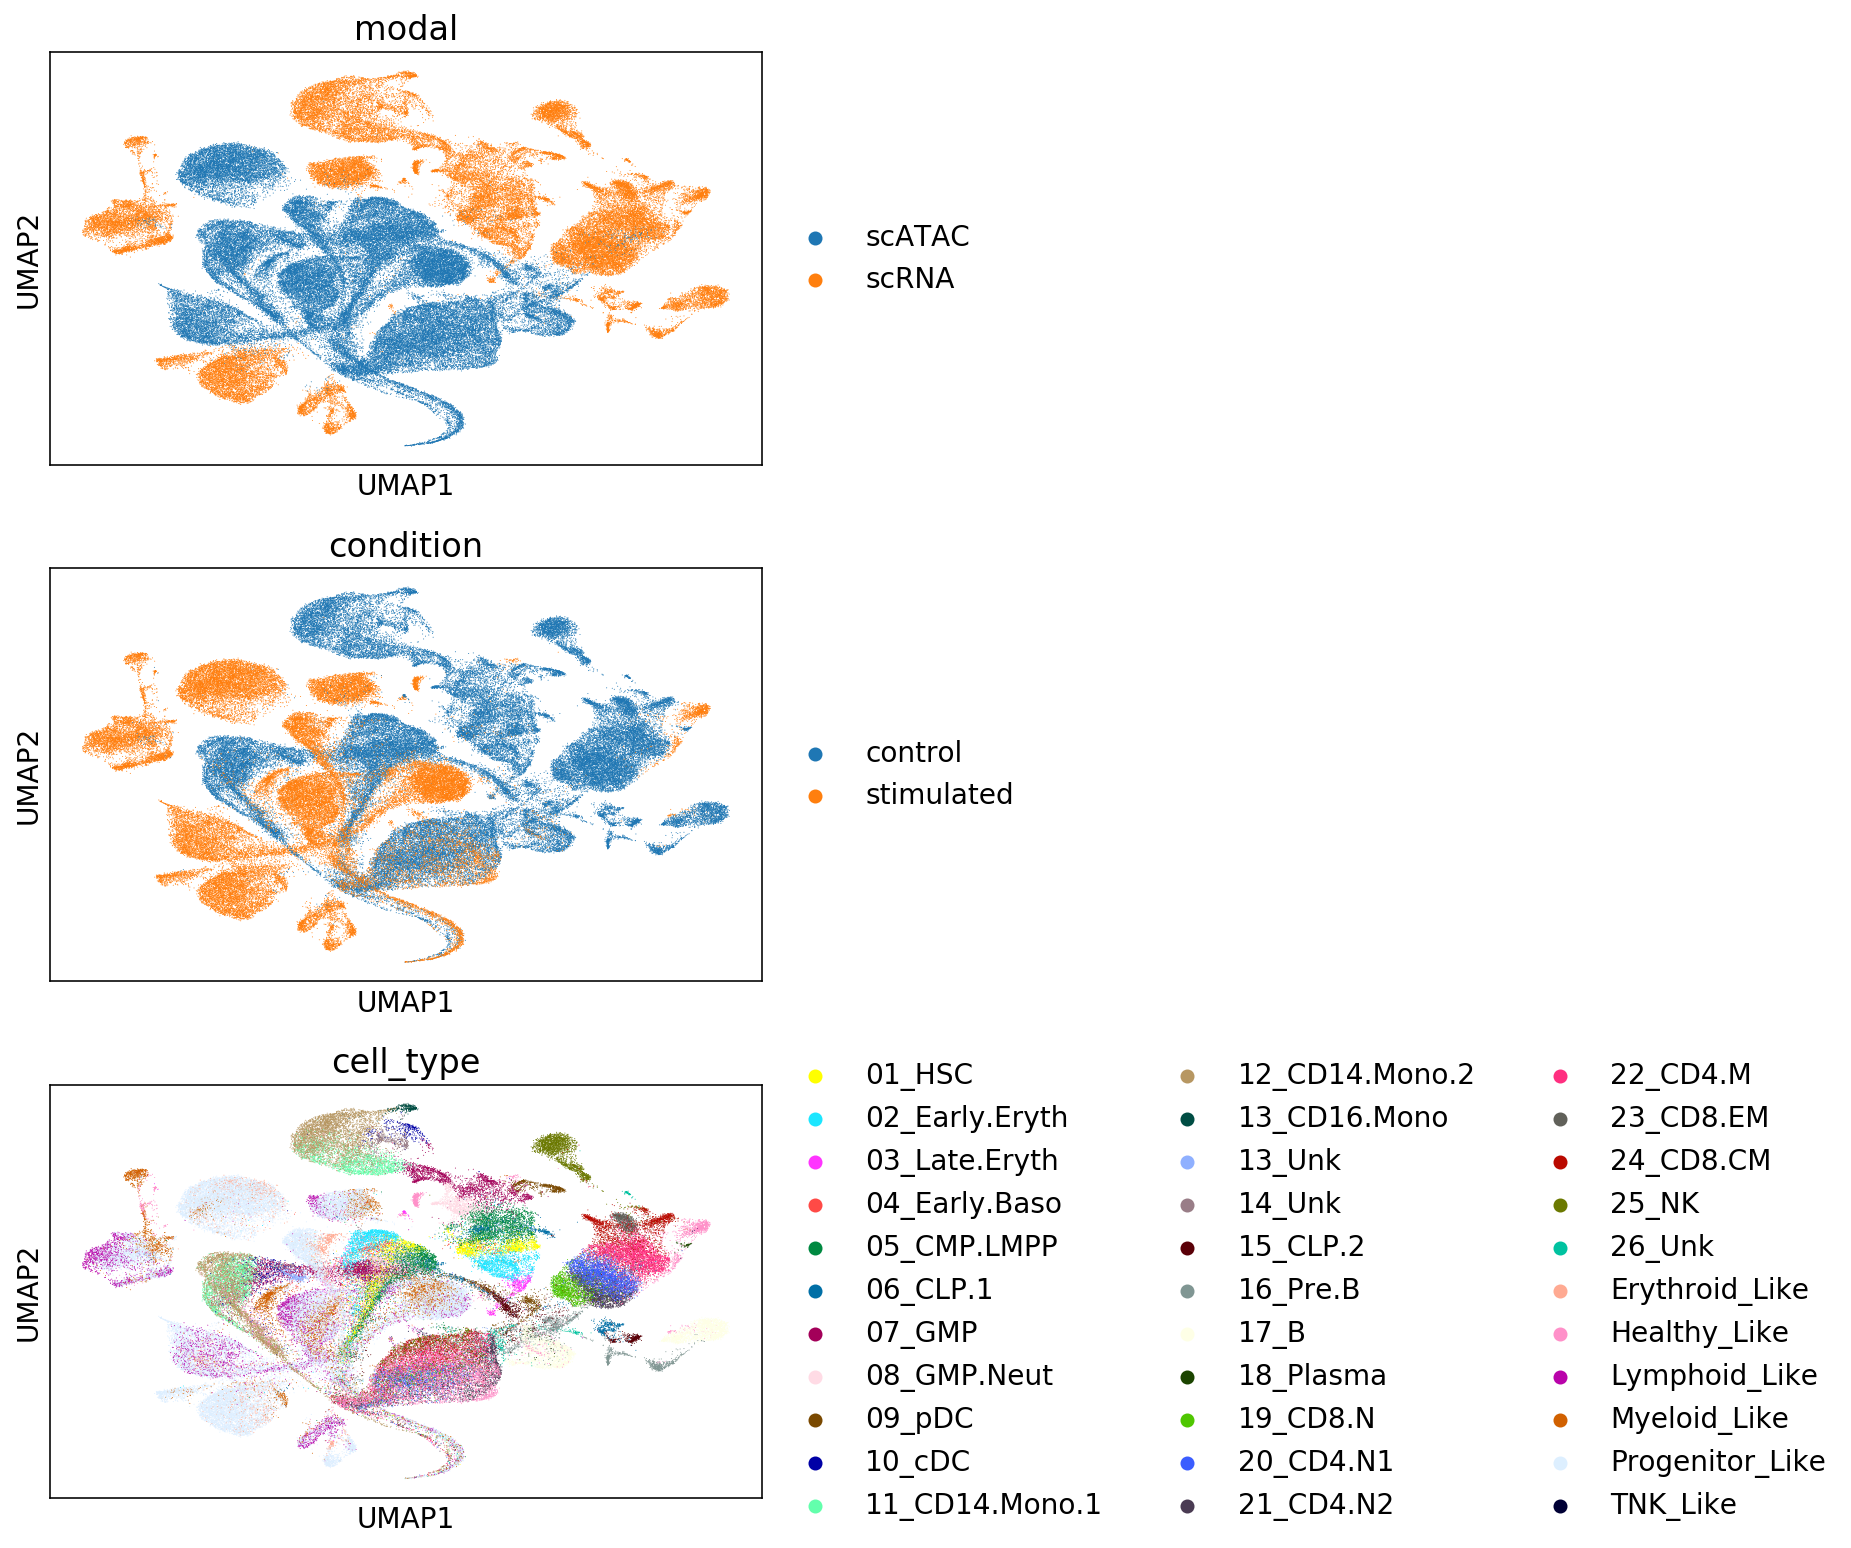

CPU times: user 17min 16s, sys: 18.4 s, total: 17min 35s
Wall time: 6min 32s


In [20]:
%%time
sc.pp.neighbors(scall_latent_intg, random_state=42)
sc.tl.umap(scall_latent_intg, random_state=42)
sc.pl.umap(scall_latent_intg, color=['modal', 'condition', 'cell_type'], ncols=1)